<a href="https://colab.research.google.com/github/AlbertoRomanRamosRodriguez/Tesis-de-Grado/blob/main/APTOS_EYEPACS_grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grading Diabetic Retinopath with APTOS and EYEPACS

In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive,move

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [3]:
aptos_csv = '/kaggle/input/aptos2019-blindness-detection/train.csv'
eyepacs_csv = '/kaggle/input/eyepacspreprocess/trainLabels.csv'
dataframes = [pd.read_csv(csv) for csv in [aptos_csv, eyepacs_csv]]

name_mappings = {
    'id_code': 'image',
    'diagnosis': 'level'
}


for d, extension in zip(dataframes, ['.png', '.jpeg']):
  d.rename(columns=name_mappings, inplace=True)
  d['image'] = d['image']+ extension
  display(d.head())

bd_names = ('APTOS 19', 'EYEPACS')

classes = range(5)
orig_ds = pd.concat([dfn.assign(DB=bdn) for dfn, bdn in zip(dataframes, bd_names)])
orig_ds.reset_index(inplace=True)
orig_ds.drop(columns=['index'], inplace=True)
orig_ds

,image,level
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


,image,level,DB
0,000c1434d8d7.png,2,APTOS 19
1,001639a390f0.png,4,APTOS 19
2,0024cdab0c1e.png,1,APTOS 19
3,002c21358ce6.png,0,APTOS 19
4,005b95c28852.png,0,APTOS 19
...,...,...,...
38765,44347_right.jpeg,0,EYEPACS
38766,44348_left.jpeg,0,EYEPACS
38767,44348_right.jpeg,0,EYEPACS
38768,44349_left.jpeg,0,EYEPACS


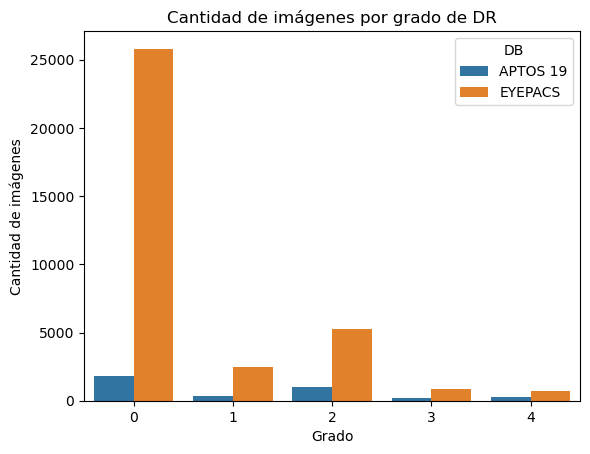

In [4]:
# Create the bar plot
sns.countplot(x='level', data=orig_ds, hue='DB')

# Set the plot title and axis labels
plt.title('Cantidad de imágenes por grado de DR')
plt.xlabel('Grado')
plt.ylabel('Cantidad de imágenes')

# Show the plot
plt.savefig('distribution.jpg')
plt.show()

level
0    27607
1     2808
2     6287
3     1065
4     1003
Name: image, dtype: int64

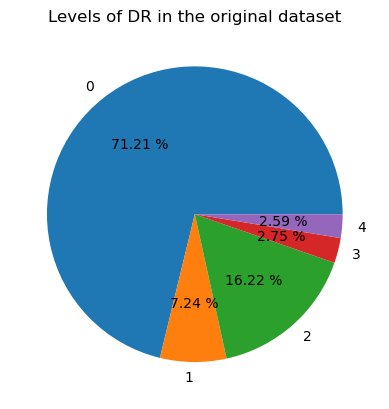

In [5]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

DB_PATH = './DB'
reset_path(DB_PATH)

display(orig_ds.groupby('level')['image'].count())

classes = 5
plt.pie([orig_ds.loc[orig_ds['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the original dataset")
img_path = os.path.sep.join([DB_PATH, 'distribution-pie.jpg'])
plt.savefig(img_path)
plt.show()

level
0    1000
1    1000
2    1000
3    1000
4    1000
Name: image, dtype: int64

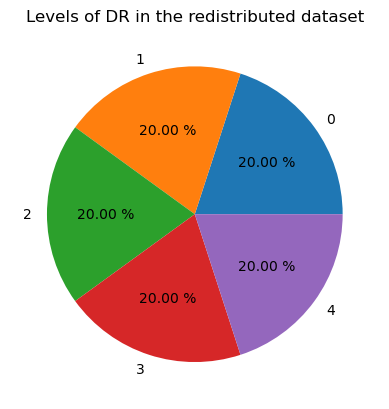

In [6]:
dataset = orig_ds.groupby(['level']).sample(1000)
display(dataset.groupby('level')['image'].count())

plt.pie([dataset.loc[dataset['level'] == n].count()[0] for n in range(classes)], labels = range(classes), autopct='%.2f %%')
plt.title("Levels of DR in the redistributed dataset")
plt.show()

In [7]:
x_train, x_remain, y_train, y_remain = train_test_split(
    dataset['image'],
    dataset['level'],
    train_size=0.8,
    test_size=0.2,
    random_state=42
)

train_df = pd.DataFrame()
train_df['image'] = x_train
train_df['level'] = y_train

remain_df = pd.DataFrame()
remain_df['image'] = x_remain
remain_df['level'] = y_remain

x_val, x_test, y_val, y_test = train_test_split(
    remain_df['image'],
    remain_df['level'],
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

val_df = pd.DataFrame()
val_df['image'] = x_val
val_df['level'] = y_val

test_df = pd.DataFrame()
test_df['image'] = x_test
test_df['level'] = y_test

display(train_df.groupby(['level'])['image'].count())
display(train_df.head())
display(val_df.groupby(['level'])['image'].count())
display(val_df.head())
display(test_df.groupby(['level'])['image'].count())
display(test_df.head())

level
0    784
1    810
2    808
3    790
4    808
Name: image, dtype: int64

,image,level
18477,18567_left.jpeg,4
9904,7853_left.jpeg,4
9995,7964_right.jpeg,0
21878,22959_left.jpeg,3
538,26463a5fb949.png,4


level
0    108
1     96
2     96
3    103
4     97
Name: image, dtype: int64

,image,level
21677,22712_right.jpeg,2
1068,4c570172778b.png,3
17391,17234_left.jpeg,2
16772,16488_right.jpeg,1
28921,31987_right.jpeg,0


level
0    108
1     94
2     96
3    107
4     95
Name: image, dtype: int64

,image,level
31396,35124_left.jpeg,3
35309,39987_right.jpeg,0
12787,11462_left.jpeg,2
21821,22887_right.jpeg,1
18842,19018_left.jpeg,3


In [8]:
path_dict = {p:os.listdir(p)
              for p in ['/kaggle/input/aptos2019-blindness-detection/train_images', '/kaggle/input/eyepacspreprocess/eyepacs_preprocess/eyepacs_preprocess']}
path_dict

{'/kaggle/input/aptos2019-blindness-detection/train_images': ['ef476be214d4.png',
  '6dcde47060f9.png',
  'ec363f48867b.png',
  '17f6c7072f61.png',
  'b49b2fac2514.png',
  'af6166d57f13.png',
  '8d13c46e7d75.png',
  'c3b15bf9b4bc.png',
  'be68322c7223.png',
  '88e4399d207c.png',
  '0243404e8a00.png',
  '77ab222bf85c.png',
  '4a05f81b3aba.png',
  '61d9c88a3a4b.png',
  '8448af27ba07.png',
  '4554062fa836.png',
  'a688f20f8895.png',
  'f481f76a6b75.png',
  '3af9aaa880e9.png',
  'cb68fce07789.png',
  '5d9c841eb245.png',
  'd4be0403e6ab.png',
  '388f12e8df0b.png',
  'bb7e0a2544cd.png',
  '1d29cb2f4296.png',
  '0083ee8054ee.png',
  'd83c3efade75.png',
  '2927665214e1.png',
  '1e4650743fa2.png',
  '0ac436400db4.png',
  '0d0a21fd354f.png',
  'abdb365cacbc.png',
  'd15ca3469b87.png',
  '576e189d23d4.png',
  '02da652c74b8.png',
  '33ffddea8c6e.png',
  '28f93cad89c5.png',
  '8af50c9d0a86.png',
  '15e96e848b46.png',
  '932181b93b2f.png',
  'fa7fa797c650.png',
  'c68dfa021d62.png',
  '059bc89df7f4.

In [9]:
def clahe_image(path:str):
    # Load the image
    img = cv2.imread(path)
    # mask = cv2.imread('mask.png', 0)

    # Extract the green plane
    green_plane = img[:, :, 1]

    # Define the FA-CLAHE algorithm
    faclahe = cv2.createCLAHE(clipLimit=4.5, tileGridSize=(22, 22))

    # Apply the FA-CLAHE algorithm to the green plane
    faclahe_img = faclahe.apply(green_plane)

    # masked_img = cv2.bitwise_and(faclahe_img, faclahe_img, mask=mask)

    cv2.imwrite(path, faclahe_img)

In [10]:
from shutil import copy
import cv2

splits = [
    (train_df, 'train'),
    (val_df, 'val'),
    (test_df, 'test')
]

for df, set_path in splits:
  df['level'] = df['level'].astype('str')
  ds_dict = df.to_dict(orient='index')
  set_path = os.path.join(DB_PATH, set_path)
  if not os.path.exists(set_path):
    os.mkdir(set_path)

  for datapoint in ds_dict.values():
    orig_path = ''
    for p, imgs in path_dict.items():
        orig_path = os.path.join(p, datapoint['image']) if datapoint['image'] in imgs else orig_path

    if orig_path == '':
      raise ValueError
    dest_path = os.path.join(set_path, datapoint['level'])
    
    if not os.path.exists(dest_path):
      os.mkdir(dest_path)
    
    dest_path = os.path.join(dest_path, datapoint['image'])

    copy(orig_path, dest_path)
    clahe_image(dest_path)

    print(f'Copied {dest_path}')

Copied ./DB/train/4/18567_left.jpeg
Copied ./DB/train/4/7853_left.jpeg
Copied ./DB/train/0/7964_right.jpeg
Copied ./DB/train/3/22959_left.jpeg
Copied ./DB/train/4/26463a5fb949.png
Copied ./DB/train/2/1290_right.jpeg
Copied ./DB/train/4/25985_left.jpeg
Copied ./DB/train/4/37708_left.jpeg
Copied ./DB/train/2/5e18af29d812.png
Copied ./DB/train/2/27624_left.jpeg
Copied ./DB/train/3/16374_right.jpeg
Copied ./DB/train/1/582115961a3d.png
Copied ./DB/train/3/adb56cecafaf.png
Copied ./DB/train/3/71a39c660432.png
Copied ./DB/train/2/15138_left.jpeg
Copied ./DB/train/2/39294_left.jpeg
Copied ./DB/train/0/b7ce561a7328.png
Copied ./DB/train/4/37813_left.jpeg
Copied ./DB/train/3/3868_right.jpeg
Copied ./DB/train/4/11854_left.jpeg
Copied ./DB/train/4/bcd503c726ba.png
Copied ./DB/train/4/32851_right.jpeg
Copied ./DB/train/0/9096_left.jpeg
Copied ./DB/train/4/35861_right.jpeg
Copied ./DB/train/1/3de8ad4151e1.png
Copied ./DB/train/1/5441_right.jpeg
Copied ./DB/train/2/43307_left.jpeg
Copied ./DB/train/4

In [29]:
# ResNet Grading of Diabetic Retinopathy in PyTorch
from __future__ import print_function, division

from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sn
import pandas as pd
import numpy as np
import torchvision
import torch
import time
import copy
import os

cudnn.benchmark = True
plt.ion()   # interactive mode

## Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, starting_loss = float('inf'), warmup_epochs = 0):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = starting_loss
    best_acc = 0.0 
    
    total_epochs = num_epochs+warmup_epochs
    try:
        for epoch in range(total_epochs):
            print(f'Epoch {epoch+1}/{total_epochs}')
            
            if warmup_epochs != 0 and epoch == (warmup_epochs - 1):
                for param in model_ft.parameters():
                    param.requires_grad = True
                print(f"Starting full training")
            elif warmup_epochs != 0 and epoch <= (warmup_epochs - 1):
                print(f"{warmup_epochs-epoch+1} warmup epochs remaining")
            elif warmup_epochs != 0 and epoch == 0:
                print(f"Starting warmup training")
            elif epoch == 0:
                print("Training without warmup")
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward
                    # Track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Update best validation loss and model weights
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best model found with validation loss: {best_loss:.4f}')

            print()

    except KeyboardInterrupt:
        pass

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_loss:.4f} | Best validation accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return (best_loss, model)




def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
#     if not os.path.exists('')

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(sample_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                title = f'predicted: {class_names[preds[j]]}, label: {labels[j]}'
                imshow(inputs.cpu().data[j], title=title, fig_size=(12,7))
                
                if not os.path.exists(os.path.join('output', 'prediction_examples')):
                    os.mkdir(os.path.join('output', 'prediction_examples'))
                path = os.path.join('output', 'prediction_examples',f'test_image-{j}.jpg')
                plt.savefig(path)
                plt.show()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


Using device cuda


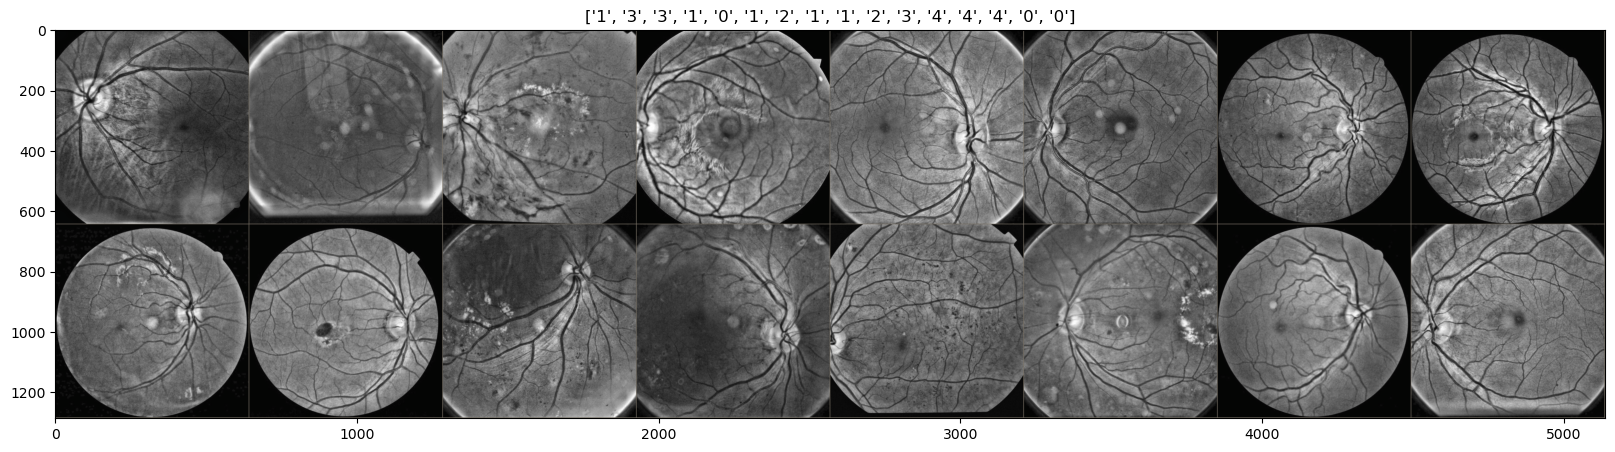

In [16]:
## Load Data
IM_SIZE = 640
batch_size = 16
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IM_SIZE),
        transforms.CenterCrop(IM_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

DATA_DIR = 'DB'
ds_splits = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ds_splits}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ds_splits[:2]}

sample_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                        shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                        shuffle=False, num_workers=2)

dataset_sizes = {x: len(image_datasets[x]) for x in ds_splits}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Using device {device}')

def imshow(inp, title=None, fig_size=(12,7)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=fig_size)
#     plt.savefig('batch.jpg')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes], fig_size=(20,15))

In [17]:
import datetime

TIME_STAMP = datetime.datetime.today().strftime('%d_%h_%y_%H_%M')
model_weights = models.ResNet50_Weights.DEFAULT

model_ft = models.resnet50(weights=model_weights)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)
model_ft = nn.DataParallel(model_ft)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(
    model_ft.parameters(), 
    lr=0.01, 
    weight_decay=1e-5, 
    momentum=0.9
)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [21]:
warmup_epochs = 7
training_epochs = 25

print(f"Training on device {device}")
# for param in model_ft.parameters():
#     param.requires_grad = False

best_train_loss, model_ft = train_model(
    model = model_ft, 
    criterion = criterion, 
    optimizer = optimizer_ft, 
    scheduler = exp_lr_scheduler,
    num_epochs = training_epochs,
    warmup_epochs = warmup_epochs
    
)

Training on device cuda
Epoch 1/32
8 warmup epochs remaining
----------
train Loss: 1.4593 Acc: 0.3380
val Loss: 1.3599 Acc: 0.3920
New best model found with validation loss: 1.3599

Epoch 2/32
7 warmup epochs remaining
----------
train Loss: 1.3752 Acc: 0.3915
val Loss: 1.2523 Acc: 0.4340
New best model found with validation loss: 1.2523

Epoch 3/32
6 warmup epochs remaining
----------
train Loss: 1.3276 Acc: 0.4230
val Loss: 1.3246 Acc: 0.4320

Epoch 4/32
5 warmup epochs remaining
----------
train Loss: 1.2860 Acc: 0.4507
val Loss: 1.1804 Acc: 0.4900
New best model found with validation loss: 1.1804

Epoch 5/32
4 warmup epochs remaining
----------
train Loss: 1.2734 Acc: 0.4482
val Loss: 1.2815 Acc: 0.4240

Epoch 6/32
3 warmup epochs remaining
----------
train Loss: 1.2451 Acc: 0.4642
val Loss: 1.2958 Acc: 0.4300

Epoch 7/32
Starting full training
----------
train Loss: 1.2250 Acc: 0.4587
val Loss: 1.1254 Acc: 0.4840
New best model found with validation loss: 1.1254

Epoch 8/32
-----

In [22]:
if not os.path.exists('models'):
  os.mkdir('models')

FILENAME = f"{model_weights}_{warmup_epochs}_{training_epochs}_{best_train_loss}_Grading_{TIME_STAMP}"
print(f'{FILENAME}')
MODEL_PATH = f'{FILENAME}.pt'
torch.save(model_ft.state_dict(), MODEL_PATH)

ResNet50_Weights.IMAGENET1K_V2_7_25_1.079264066696167_Grading_02_May_23_19_59


In [ ]:
y_pred = []
y_true = []
# iterate over test data
print("[INFO] Iterating predictions")

# device = torch.device("cpu")
# model_ft = model_ft.to(device)
model_ft.eval()

for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
                
print("[INFO] Finished iterating predictions")

# constant for classes
classes = ('No DR', 'Mild NPDR', 'Moderate NPDR', 'Severe NPDR', 'Proliferative DR')

def get_matrix(cfm: np.ndarray, pct:True):
        if pct:
                return cfm / np.sum(cfm, axis=1)
        else:
                return cfm

if not os.path.exists('output'):
  os.mkdir('output')
OUTPATH = os.path.sep.join(['output',f'{FILENAME}'])
if not os.path.exists(OUTPATH):
        os.mkdir(OUTPATH)

visualize_model(model_ft)
print("[INFO] Building Matrix")
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
for pct in (False, True):
        df_cm = pd.DataFrame(get_matrix(cfm=cf_matrix,pct=pct), index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True, fmt='g')
        cm_path = os.path.sep.join([OUTPATH, f'confusion_matrix_pct_{pct}.png'])
        plt.savefig(cm_path)

[INFO] Iterating predictions
[INFO] Finished iterating predictions


<Figure size 640x480 with 0 Axes>